<a href="https://colab.research.google.com/github/laurafiorini/helmet-detection/blob/main/Helmet_detection_with_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Usando YOLO para detectar o uso de capacetes por motociclistas

Este notebook tem o objetivo de treinar o modelo YOLO (versões YOLOv5 e YOLOv10) para a tarefa de detecção de capacetes, a partir de imagens de motociclistas e ciclistas, em sua maioria.

## Instalações e configurações iniciais

In [ ]:
# Define home directory
import os
HOME_DIR = "/content" # os.getcwd()
print(HOME_DIR)

/content


In [ ]:
!pip install ultralytics --quiet

In [ ]:
# Import necessary modules and libs
from glob import glob
from collections import Counter
import cv2
import yaml
import random
import shutil
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from ultralytics import YOLO

In [ ]:
logging = False

*🚧 ATENÇÃO: Descomente a célula abaixo se quiser registrar os experimentos no Dagshub/MLflow*

In [ ]:
# # Install and import dagshub and mlflow for experiment logging

# !pip install dagshub --quiet
# !pip install mlflow --quiet

# import dagshub
# import mlflow

# logging = True

## Importando os datasets estudados do Kaggle

*🚧 ATENÇÃO: Para rodar a próxima célula é necessário possuir uma conta no [Kaggle](https://www.kaggle.com/).*

In [ ]:
!pip install opendatasets --quiet

import opendatasets as od

# Download both datasets
od.download("https://www.kaggle.com/datasets/aneesarom/rider-with-helmet-without-helmet-number-plate/")
od.download("https://www.kaggle.com/datasets/andrewmvd/helmet-detection/")

Skipping, found downloaded files in "./rider-with-helmet-without-helmet-number-plate" (use force=True to force download)
Skipping, found downloaded files in "./helmet-detection" (use force=True to force download)


## Montando o Google Drive

Isso é especialmente necessário para importar as labels criadas manualmente do dataset 2 (*helmet-detection*) e importadas para o Google Drive.

In [ ]:
from google.colab import drive

# Mount drive
drive.mount(os.path.join(HOME_DIR, 'gdrive'), force_remount=False)

Mounted at /content/gdrive


## Organizando os datasets

### Dataset 1 (*rider-with-helmet-without-helmet-number-plate*)

Usado como dataset principal por já ser tratado, de acordo com o formato usado pelo Yolo, e por já ter os dados devidamente divididos como o necessário para o desenvolvimento do projeto.

É usado principalmente para entender das classes/categorias utilizadas no trabalho, além de auxiliar no desenvolvimento do arquivo .yaml utilizado pelo Yolo mais adiante.

Apesar disso, é um dataset com poucas imagens para realizar testes, treinamentos e validações, e por isso, usa-se mais um.

In [ ]:
### DATASET 1 ###

# Define main dataset 1 path
dataset1_path = "/content/rider-with-helmet-without-helmet-number-plate"

# Map classes to their index in the classes.txt file
def get_class_map():
  with open(f"{dataset1_path}/classes.txt", 'r') as file:
    data = file.read().strip().split('\n')

    class_map = { }
    for i in range(len(data)):
      class_map[i] = data[i]

    return class_map

class_map = get_class_map()

Cria o arquivo .yaml necessário para o funcionamento do Yolo.

In [ ]:
print("Reading yaml file from dataset 1...")

# Read yaml file contents from dataset1
dataset1_yaml_path = f"{dataset1_path}/coco128.yaml"
with open(dataset1_yaml_path, 'r') as file:
  print(file.read())

# Set a new yaml file for the merged datasets
new_dataset1_yaml_path = os.path.join(dataset1_path, 'data.yaml')
yaml_content = f"""
train: {dataset1_path}/train/images
val: {dataset1_path}/val/images

nc: 4
names: ['with helmet', 'without helmet', 'rider', 'number plate']
"""

# Write the dataset configuration to a yaml file
with open(new_dataset1_yaml_path, 'w') as yaml_file:
    yaml_file.write(yaml_content)

print(f"\nNew yaml file for merged datasets was written successfully at location {new_dataset1_yaml_path}")

Reading yaml file from dataset 1...
train: /train/images
val: /val/images

nc: 4

names: ["with helmet", "without helmet", "rider", "number plate"]

New yaml file for merged datasets was written successfully at location /content/rider-with-helmet-without-helmet-number-plate/data.yaml


### Dataset 2 (*helmet-detection*)

É um dataset com mais imagens que o dataset 1, apesar de abordar também diversas imagens de bicicletas, ao invés de apenas motocicletas, por exemplo. Apesar disso, ainda se faz útil nesse sentido, fornecendo imagens necessárias para um melhor treinamento da rede.

As *labels* desse dataset foram criadas de duas formas. Primeiramente, elas foram diretamente convertidas de .xml para .txt (formato do Yolo) por meio de funções de Python.

Após isso, visto que elas estavam classificadas em somente duas das quatro classes desejadas de se estudar, elas foram manualmente "etiquetadas" por meio de softwares terceiros, a fim de classificar de forma melhor e estender para as quatro classes existentes no projeto.

As *labels* foram então geradas em arquivos .txt e upadas no Drive, para poderem ser utilizadas neste Google Colab.


*🚧 ATENÇÃO: Para rodar esta célula, adicione um atalho para a pasta [labels_dataset_2](https://drive.google.com/drive/folders/1nDzYN4L1-OSq8a0nGyiQrVNXArhlonne?usp=sharing) no "Meu Drive", o diretório principal do seu Google Drive.*

In [ ]:
### DATASET 2 ###
# Only run when you have the files on your local drive

def get_labels_from_drive(drive_path):
  return [img for img in os.listdir(drive_path)]

txt_labels = get_labels_from_drive(os.path.join(HOME_DIR, '/content/gdrive/MyDrive/labels_dataset_2'))

Conversões diretas de .xml para .txt a seguir.

In [ ]:
### DATASET 2 ###

dataset2_path = "/content/helmet-detection"

# Parse and get the basic image information from the specified annotation xml file
def parse_xml_file(xml_file):
  # Parse specified XML file
  xml = ET.parse(xml_file)
  root = xml.getroot()

  # Get basic image information from xml file
  image_name = root.find('filename').text
  image_width = int(root.find('size/width').text)
  image_height = int(root.find('size/height').text)
  image_depth = int(root.find('size/depth').text)
  image_shape = image_width, image_height, image_depth

  labels_and_bboxes = []

  # Loop through each object in the XML
  for obj in root.findall('object'):
      # Extract label and bounding box coordinates for each object
      label = obj.find('name').text.lower()
      xmin = int(obj.find('bndbox/xmin').text)
      ymin = int(obj.find('bndbox/ymin').text)
      xmax = int(obj.find('bndbox/xmax').text)
      ymax = int(obj.find('bndbox/ymax').text)

      # Append label and bounding box to the list
      labels_and_bboxes.append((label, (xmin, ymin, xmax, ymax)))

  return image_name, image_shape, labels_and_bboxes

# Convert bounding box values from .xml files to YOLO standards
def convert_bbox_to_yolo(image_shape, bbox):
  # bbox coordinates are defined as:
  # bbox[0] = xmin, bbox[1] = ymin, bbox[2] = xmax, bbox[3] = ymax

  # image_shape is defined as:
  # image_shape[0] = width, image_shape[1] = height, image_shape[2] = depth

  # Compute bounding box center, width and height from bbox coordinates
  x_center = (bbox[0] + bbox[2]) / 2
  y_center = (bbox[1] + bbox[3]) / 2
  width = bbox[2] - bbox[0]
  height = bbox[3] - bbox[1]

  # Normalize all values between 0 and 1
  x_center /= image_shape[0]
  y_center /= image_shape[1]
  width /= image_shape[0]
  height /= image_shape[1]

  return x_center, y_center, width, height

In [ ]:
# Convert labels from .xml to .txt file
def xml_to_txt_label(annotations_dir, labels_dir):
  # Create labels folder
  os.makedirs(labels_dir, exist_ok=True)

  # Gather all annotation xml files and append to a list
  annotations = [ ]
  for file in os.listdir(annotations_dir):
    if file.lower().endswith('.xml'):
      annotations.append(file)

  valid_counter = 0
  corrupted_counter = 0

  for xml_file in annotations:
    file_corrupt = False

    # Browse through annotation xml files and extract the class and bounding box coordinates
    image_name, image_shape, labels_and_bboxes = parse_xml_file(os.path.join(annotations_dir, xml_file))

    png_file = os.path.join(f"{dataset2_path}/images", image_name)
    txt_file = os.path.join(labels_dir, xml_file.replace('.xml', '.txt'))

    with open(txt_file, 'w') as label_file:
      # Check whether there is any information for the image
      if not labels_and_bboxes:
        file_corrupt = True

      for label, bbox in labels_and_bboxes:
        # Map label to a number that matches the other dataset
        if label == 'with helmet':
          label = 0
        else:
          label = 1

        x_center, y_center, width, height = convert_bbox_to_yolo(image_shape, bbox)

        # Check if values are within the range 0 and 1
        if x_center > 1 or y_center > 1 or width > 1 or height > 1:
            file_corrupt = True
            break

        # Write data to .txt file as YOLO standards
        label_file.write(f"{label} {x_center} {y_center} {width} {height}\n")

    # Delete corrupted files
    if file_corrupt:
        corrupted_counter += 1

        label_file.close()
        os.remove(txt_file)

        continue

    valid_counter += 1
    # print(f"\rCreating label for {image_name}", end='', flush=True)

  print(f"\n> {valid_counter} labels successfully created! | {corrupted_counter} images ignored!")

xml_to_txt_label(f"{dataset2_path}/annotations", f"{dataset2_path}/labels")


> 746 labels successfully created! | 18 images ignored!


Como nem todas as imagens foram úteis o suficiente para a geração de *labels* manuais (imagens repetidas na maior parte das vezes), estas foram devidamente filtradas do dataset.

In [ ]:
# Only run when you have the files on your local drive
drive_label_path = os.path.join(HOME_DIR, '/content/drive/MyDrive/UFSC/12 fase/Visão Computacional/Datasets/labels_dataset_2')

# Return only images that contains an existing label.txt
def clean_dataset_based_on_labels(images_dir, labels_dir):
  labels = get_labels_from_drive(labels_dir)
  labels = [label[:-4] for label in labels]

  result = [ ]
  for image in os.listdir(images_dir):
    if (image[:-4] in labels):
      result.append(image)

  print("Full dataset:", len(os.listdir(images_dir)))
  print("Cleaned dataset:", len(result))

clean_dataset_based_on_labels(f"{dataset2_path}/images", drive_label_path)

Full dataset: 764
Cleaned dataset: 627


#### Separação do dataset 2 em *train*, *val* e *test*

Como este dataset é maior que o primeiro, as imagens são separadas em imagens de treino, validação e teste, seguindo a proporção de 70%, 20% e 10%, respectivamente.

In [ ]:
train_image_dir = os.path.join(dataset2_path, "train", "images")
train_labels_dir = os.path.join(dataset2_path, "train", "labels")

val_image_dir = os.path.join(dataset2_path, "val", "images")
val_labels_dir = os.path.join(dataset2_path, "val", "labels")

test_image_dir = os.path.join(dataset2_path, "test", "images")
test_labels_dir = os.path.join(dataset2_path, "test", "labels")

# Split images between train (80%) and val (20%)
def split_train_and_val(images_dir, labels_dir):
  # Make sure target directory exists
  for dir in [train_image_dir, val_image_dir, train_labels_dir, val_labels_dir, test_image_dir, test_labels_dir]:
    os.makedirs(dir, exist_ok=True)

  # Copy images randomly to train and val folders using 80/20 split
  images = [img[:-4] for img in os.listdir(images_dir)]
  random.shuffle(images)
  split_1 = int(0.7 * len(images))
  split_2 = int(0.9 * len(images))

  count_total = len(images)
  count_train = 0
  count_val = 0
  count_test = 0
  count_ignored = 0

  for i in range(len(images)):
    # Check if label exists and ignore corrupted ones
    if not os.path.exists(os.path.join(labels_dir, f"{images[i]}.txt")):
        count_ignored += 1
        count_total -= 1
        continue

    if i < split_1:
        shutil.copy(os.path.join(images_dir, f"{images[i]}.png"), train_image_dir)
        shutil.copy(os.path.join(labels_dir, f"{images[i]}.txt"), train_labels_dir)
        count_train += 1
    elif i < split_2:
        shutil.copy(os.path.join(images_dir, f"{images[i]}.png"), val_image_dir)
        shutil.copy(os.path.join(labels_dir, f"{images[i]}.txt"), val_labels_dir)
        count_val += 1
    else:
        shutil.copy(os.path.join(images_dir, f"{images[i]}.png"), test_image_dir)
        shutil.copy(os.path.join(labels_dir, f"{images[i]}.txt"), test_labels_dir)
        count_test += 1

    count_total -= 1

    print(f"\rTotal images: {count_total} >> Train: {count_train} | Val: {count_val} | Test: {count_test} | Ignored: {count_ignored}", end='', flush=True)

# split_train_and_val(f"{dataset2_path}/images", f"{dataset2_path}/labels")
split_train_and_val(f"{dataset2_path}/images", drive_label_path)

Total images: 0 >> Train: 434 | Val: 123 | Test: 70 | Ignored: 137

#### *Merge* dos dois datasets

A fim de trabalhar com os dois datasets em conjunto, coloca-se ambos juntos em uma pasta de *merged-datasets*, já que agora eles já possuem a mesma estrutura de arquivos, classes e classificações.

In [ ]:
merged_train_image_dir = os.path.join(f"{HOME_DIR}/merged-datasets", "train", "images")
merged_train_label_dir = os.path.join(f"{HOME_DIR}/merged-datasets", "train", "labels")

merged_val_image_dir = os.path.join(f"{HOME_DIR}/merged-datasets", "val", "images")
merged_val_label_dir = os.path.join(f"{HOME_DIR}/merged-datasets", "val", "labels")

merged_test_image_dir = os.path.join(f"{HOME_DIR}/merged-datasets", "test", "images")
merged_test_label_dir = os.path.join(f"{HOME_DIR}/merged-datasets", "test", "labels")

# Copy files from the source path to a destination path
def copy_data(source_path, destination_path):
  for data in os.listdir(source_path):
    shutil.copy(os.path.join(source_path, data), destination_path)

# Merge both used datasets together
def merge_datasets():
  # Make sure target directory exists
  for dir in [merged_train_image_dir, merged_train_label_dir,
              merged_val_image_dir, merged_val_label_dir,
              merged_test_image_dir, merged_test_label_dir]:
    os.makedirs(dir, exist_ok=True)

  # Copy data to the corresponding folder
  for dataset in [dataset1_path, dataset2_path]:
    copy_data(os.path.join(dataset, "train/images"), merged_train_image_dir)
    copy_data(os.path.join(dataset, "train/labels"), merged_train_label_dir)
    copy_data(os.path.join(dataset, "val/images"), merged_val_image_dir)
    copy_data(os.path.join(dataset, "val/labels"), merged_val_label_dir)

    copy_data(os.path.join(dataset2_path, "test/images"), merged_test_image_dir)
    copy_data(os.path.join(dataset2_path, "test/labels"), merged_test_label_dir)

merge_datasets()

Cria o arquivo .yaml necessário para o funcionamento do Yolo.

In [ ]:
merged_datasets_path = f"{HOME_DIR}/merged-datasets"

print("Reading yaml file from dataset 1...")

# Read yaml file contents from dataset1
dataset1_yaml_path = f"{dataset1_path}/coco128.yaml"
with open(dataset1_yaml_path, 'r') as file:
  print(file.read())

# Set a new yaml file for the merged datasets
merged_yaml_path = os.path.join(merged_datasets_path, 'data.yaml')
yaml_content = """
train: /content/merged-datasets/train/images
val: /content/merged-datasets/val/images

nc: 4
names: ['with helmet', 'without helmet', 'rider', 'number plate']
"""

# Write the dataset configuration to a yaml file
with open(merged_yaml_path, 'w') as yaml_file:
    yaml_file.write(yaml_content)

print(f"\nNew yaml file for merged datasets was written successfully at location {merged_yaml_path}")

Reading yaml file from dataset 1...
train: /train/images
val: /val/images

nc: 4

names: ["with helmet", "without helmet", "rider", "number plate"]

New yaml file for merged datasets was written successfully at location /content/merged-datasets/data.yaml


Cria outro arquivo .yaml usando o dataset de teste para obter as métricas de inferência do modelo.

In [ ]:
# Set a new yaml file for the test file
test_merged_yaml_path = os.path.join(merged_datasets_path, 'test_data.yaml')
test_merged_yaml_content = """
train: /content/merged-datasets/train/images
val: /content/merged-datasets/test/images

nc: 4
names: ['with helmet', 'without helmet', 'rider', 'number plate']
"""

# Write the dataset configuration to a yaml file
with open(test_merged_yaml_path, 'w') as yaml_file:
    yaml_file.write(test_merged_yaml_content)

print(f"\nNew yaml file for test datasets was written successfully at location {test_merged_yaml_path}")


New yaml file for test datasets was written successfully at location /content/merged-datasets/test_data.yaml


In [ ]:
# Count the amount of instances per class for the specified label path
def count_class_instances(labels_path):
  class_counter = Counter()
  labels_path = f"{labels_path}/*.txt"

  for label_file in glob(labels_path):
    with open(label_file, "r") as file:
      data = file.read().strip().split('\n')

      for instance in data:
        class_counter[int(instance.split()[0])] += 1

  class_counter = dict(sorted(class_counter.items()))
  return class_counter

# Format and print the amount of instances per class for the specified folder
def print_class_counter(path, folder_name):
  labels_path = f"{path}/{folder_name}/labels"
  data_size = len(glob(f"{labels_path}/*.txt"))

  print(f"{int(data_size)} images found for '{path}/{folder_name}' folder.")
  print(f"Count per class: ")

  class_counter = count_class_instances(labels_path)

  for key, value in class_counter.items():
    print(f"{key} -> {class_map[key]}: {value}")

  print()

# Print counters for 'train' and 'val' folders
print_class_counter(dataset1_path, "train")
print_class_counter(dataset1_path, "val")

print_class_counter(dataset2_path, "train")
print_class_counter(dataset2_path, "val")

print_class_counter(merged_datasets_path, "train")
print_class_counter(merged_datasets_path, "val")

104 images found for '/content/rider-with-helmet-without-helmet-number-plate/train' folder.
Count per class: 
0 -> with helmet: 64
1 -> without helmet: 93
2 -> rider: 120
3 -> number plate: 116

20 images found for '/content/rider-with-helmet-without-helmet-number-plate/val' folder.
Count per class: 
0 -> with helmet: 13
1 -> without helmet: 15
2 -> rider: 23
3 -> number plate: 22

570 images found for '/content/helmet-detection/train' folder.
Count per class: 
0 -> with helmet: 870
1 -> without helmet: 727
2 -> rider: 989
3 -> number plate: 179

226 images found for '/content/helmet-detection/val' folder.
Count per class: 
0 -> with helmet: 382
1 -> without helmet: 265
2 -> rider: 380
3 -> number plate: 72

674 images found for '/content/merged-datasets/train' folder.
Count per class: 
0 -> with helmet: 934
1 -> without helmet: 820
2 -> rider: 1109
3 -> number plate: 295

246 images found for '/content/merged-datasets/val' folder.
Count per class: 
0 -> with helmet: 395
1 -> without h

#### Printa imagens

Adquire as coordenadas das *bouding boxes* das imagens etiquetadas para mostrar na tela, juntamente com as imagens resultado do Yolo.

In [ ]:
# Convert bbox data into actual coordinates for the selected image
def get_bbox_coordinates(image, bbox):
  image_height, image_width, _ = image.shape
  x_center, y_center, width, height = bbox

  # Calculate the coordinates of the bounding box for YOLO standards
  x_center_pixel = x_center * image_width
  y_center_pixel = y_center * image_height
  half_width = width * image_width / 2
  half_height = height * image_height / 2

  # Calculate the box max and min points
  x_min = int(x_center_pixel - half_width)
  y_min = int(y_center_pixel - half_height)
  x_max = int(x_center_pixel + half_width)
  y_max = int(y_center_pixel + half_height)

  return x_min, y_min, x_max, y_max

# Get label and bbox data for the specified image
def get_label_and_bbox(image_file, label_path=None):
    # Find the corresponding label file
    file_name = os.path.splitext(os.path.basename(image_file))[0]
    if label_path is None:
      label_path = f"{os.path.abspath(os.path.join(image_file, os.pardir, os.pardir))}/labels/{file_name}.txt"

    with open(label_path, 'r') as file:
        lines = file.readlines()

    labels = [ ]
    bboxes = [ ]
    for line in lines:
      line = line.split()

      labels.append(int(line[0]))
      bboxes.append(list(map(float, line[1:])))

    return labels, bboxes

In [ ]:
bbox_color = {
    0: (255, 105, 180),
    1: (0, 153, 51),
    2: (153, 51, 255),
    3: (255, 153, 0)
}

# Draw the bounding boxes on the specified image and print on the screen
def draw_bbox_on_image(image_file):
  # Load the image
  image = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
  labels, bboxes = get_label_and_bbox(image_file)

  for label, bbox in zip(labels, bboxes):
    xmin, ymin, xmax, ymax = get_bbox_coordinates(image, bbox)
    color = bbox_color[label]

    # Add rectangle and its label to the image
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)
    cv2.putText(image, class_map[label], (xmin, ymin - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # Display the image with bounding boxes
    plt.axis(False)
    plt.title(os.path.split(image_file)[-1], y=-0.1)
    plt.imshow(image)

# Select a random image from the merged-datasets train folder
def select_random_image():
  images_dir = f"{merged_datasets_path}/train/images"

  # Select a random image from the train dataset
  image_file = random.choice(os.listdir(images_dir))
  image_file = os.path.join(images_dir, image_file)
  return image_file

# image_file = select_random_image()
# draw_bbox_on_image(image_file)

In [ ]:
# Compare two images
def compare_images(image_files, label_paths=None, titles=[]):
  images = []

  if label_paths is None:
    label_paths = [None] * len(image_files)

  for i, image_file in enumerate(image_files):
      # Load the image
      image = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
      labels, bboxes = get_label_and_bbox(image_file, label_paths[i])

      for label, bbox in zip(labels, bboxes):
          xmin, ymin, xmax, ymax = get_bbox_coordinates(image, bbox)
          color = bbox_color[label]

          # Add rectangle and its label to the image
          cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)
          cv2.putText(image, class_map[label], (xmin, ymin - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

      images.append(image)
      titles.append(os.path.split(image_file)[-1])

  # Display the images with bounding boxes side by side
  fig, axs = plt.subplots(1, len(images), figsize=(15, 15))
  for ax, img, title in zip(axs, images, titles):
      ax.axis('off')
      ax.set_title(title, y=-0.1)
      ax.imshow(img)

  plt.show()

# image_file, image_file_test = select_random_image(), select_random_image()
# compare_images([image_file, image_file_test])

## Treinando o modelo YOLO

Esta seção do notebook é dedicada para o treinamento do modelo YOLO utilizando os datasets criados anteriormente, com auxílio da biblioteca Ultralytics.

Durante o experimento, foram utilizadas as versões YOLOv5 e YOLOv10, a mais recente, lançada em maio de 2024.

As diferentes rodadadas de treinamento foram acompanhadas via MLflow, hospedado no serviço Dagshub. Elas podem ser visualizadas [aqui](https://dagshub.com/laurafiorini/helmet-detection/experiments)

**O modelo que obteve a melhor performance foi o YOLOv10 pré-treinado ("yolov10n.pt"), com 50 épocas de treinamento.**

### (Opcional) Habilitando o registro dos treinamentos no MLflow/Dagshub

Quando `logging == True`, o trecho de código abaixo é usado para inicializar o repositório e experimento no MLflow/Dagshub. Para rodá-lo, é necessário alterar os parâmetros de modo que identifique um repositório ao qual se tenha acesso.

O YOLO registra "automaticamente" o progresso do treinamento no repositório.



In [ ]:
if logging:
  repo_owner = "laurafiorini"
  repo_name = "helmet-detection"
  dagshub.init(repo_name, repo_owner, mlflow=True)

  mlflow.set_tracking_uri(f'https://dagshub.com/{repo_owner}/{repo_dagshub}')

  experiment_name = 'helmet-detection'

Accessing as gustavo.witt98

Initialized MLflow to track repo "laurafiorini/helmet-detection"

Repository laurafiorini/helmet-detection initialized!

### Treinamento do modelo

Os principais parâmetros do treinamento do modelo são setados.

In [ ]:
# Set experiment details

# MODEL_NAME = "yolov5n.pt"
# MODEL_NAME = "yolov10n.yaml"
MODEL_NAME = "yolov10n.pt"

# TRAIN_DATA_YAML = new_dataset1_yaml_path
TRAIN_DATA_YAML = merged_yaml_path

EPOCHS = 50

TEST_DATA_YAML = test_merged_yaml_path
TEST_IMAGES_DIR = merged_test_image_dir

Treinamento do modelo YOLO.

In [ ]:
# Load a COCO-pretrained YOLOv5n model
model = YOLO(MODEL_NAME)

# Display model information (optional)
model.info()

# Train the model on the COCO8 example dataset for 100 epochs
results = model.train(data=TRAIN_DATA_YAML, epochs=EPOCHS, imgsz=640)

100%|██████████| 5.59M/5.59M [00:00<00:00, 41.7MB/s]


YOLOv10n summary: 385 layers, 2775520 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics YOLOv8.2.48 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=/content/merged-datasets/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_t

100%|██████████| 755k/755k [00:00<00:00, 25.4MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 98.4MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅


train: Scanning /content/merged-datasets/train/labels... 672 images, 0 backgrounds, 2 corrupt: 100%|██████████| 674/674 [00:00<00:00, 756.27it/s]

train: WARNING ⚠️ /content/merged-datasets/train/images/new128.jpg: ignoring corrupt image/label: cannot identify image file '/content/merged-datasets/train/images/new128.jpg'
train: WARNING ⚠️ /content/merged-datasets/train/images/new3.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'tiff', 'webp', 'jpeg', 'bmp', 'pfm', 'mpo', 'png', 'jpg', 'dng', 'tif'}
videos: {'ts', 'gif', 'avi', 'mp4', 'asf', 'webm', 'wmv', 'mov', 'mpg', 'mpeg', 'm4v', 'mkv'}


train: New cache created: /content/merged-datasets/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/merged-datasets/val/labels... 246 images, 0 backgrounds, 0 corrupt: 100%|██████████| 246/246 [00:00<00:00, 481.26it/s]

val: New cache created: /content/merged-datasets/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)


2024/07/02 16:32:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/07/02 16:32:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2024/07/02 16:32:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/07/02 16:32:23 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of transformers. If you encounter errors during autologging, try upgrading / downgrading transformers to a supported version, or try upgrading MLflow.
2024/07/02 16:32:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
2024/07/02 16:32:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(3090205dbeba40f7aef86f3ed377a468) to https://dagshub.com/laurafiorini/helmet-detection.mlflow
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       3.4G       2.47       6.42      2.407        191        640: 100%|██████████| 42/42 [00:28<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:09<00:00,  1.23s/it]

                   all        246       1172     0.0146      0.351      0.144     0.0991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.05G       2.39      4.213      2.365        131        640: 100%|██████████| 42/42 [00:22<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.65it/s]

                   all        246       1172      0.817      0.214      0.281       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.03G      2.483      3.742      2.382        154        640: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]

                   all        246       1172      0.597      0.303      0.432      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.08G      2.488      3.588      2.397        135        640: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.65it/s]


                   all        246       1172      0.517      0.503      0.514      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.17G      2.443      3.279      2.356        163        640: 100%|██████████| 42/42 [00:21<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.49it/s]

                   all        246       1172      0.533      0.538      0.537      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.13G       2.44      3.137      2.384        108        640: 100%|██████████| 42/42 [00:21<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


                   all        246       1172       0.63      0.563      0.615      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.13G      2.398      2.955      2.355        110        640: 100%|██████████| 42/42 [00:20<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.54it/s]

                   all        246       1172      0.657      0.643      0.682      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.22G      2.418      2.703      2.351        130        640: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.26it/s]

                   all        246       1172      0.609      0.631      0.645      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.05G      2.314      2.597      2.309        106        640: 100%|██████████| 42/42 [00:21<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]

                   all        246       1172      0.625      0.719      0.701       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.11G      2.298      2.519      2.308        170        640: 100%|██████████| 42/42 [00:21<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.68it/s]

                   all        246       1172      0.659      0.676      0.711      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.11G      2.251      2.355      2.275        119        640: 100%|██████████| 42/42 [00:21<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]

                   all        246       1172      0.678      0.682      0.721      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       3.1G      2.213      2.265      2.273        107        640: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.53it/s]

                   all        246       1172      0.701      0.744      0.773      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.01G      2.279      2.201      2.257        162        640: 100%|██████████| 42/42 [00:21<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.37it/s]

                   all        246       1172      0.717      0.726      0.776      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.05G      2.237      2.118      2.244         84        640: 100%|██████████| 42/42 [00:23<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]

                   all        246       1172      0.703      0.706       0.77      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.23G      2.156      2.061      2.219        195        640: 100%|██████████| 42/42 [00:21<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.65it/s]

                   all        246       1172      0.715      0.711      0.763      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.23G      2.172      1.997      2.244        203        640: 100%|██████████| 42/42 [00:20<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.54it/s]

                   all        246       1172      0.728      0.756      0.795      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.07G      2.166      1.999      2.228        114        640: 100%|██████████| 42/42 [00:21<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]

                   all        246       1172      0.757      0.729      0.799      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       3.1G      2.114       1.95      2.211        200        640: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]

                   all        246       1172      0.759      0.756      0.805      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.24G      2.122      1.892      2.197        130        640: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.21it/s]

                   all        246       1172      0.789      0.761      0.829      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.08G      2.068      1.794      2.184        157        640: 100%|██████████| 42/42 [00:21<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]

                   all        246       1172      0.771      0.737      0.831      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.05G      2.076      1.792      2.186         92        640: 100%|██████████| 42/42 [00:20<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]

                   all        246       1172       0.77      0.736      0.832      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.13G       2.09      1.773      2.207        119        640: 100%|██████████| 42/42 [00:21<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]

                   all        246       1172      0.749       0.78      0.833      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.07G      2.018      1.664      2.161        123        640: 100%|██████████| 42/42 [00:21<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]

                   all        246       1172      0.784      0.775      0.845      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.14G      2.017      1.691      2.158        115        640: 100%|██████████| 42/42 [00:21<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        246       1172      0.823      0.776       0.86      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.13G      1.959      1.623      2.133        133        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]

                   all        246       1172      0.817      0.786       0.86      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.12G      2.004      1.647       2.15        137        640: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.37it/s]

                   all        246       1172      0.834      0.758       0.86      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.27G      1.979      1.598      2.108        149        640: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]

                   all        246       1172      0.829      0.772       0.86      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.13G      1.926      1.576      2.105        113        640: 100%|██████████| 42/42 [00:23<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.67it/s]

                   all        246       1172      0.843      0.789      0.887      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.16G       1.96      1.563      2.113        155        640: 100%|██████████| 42/42 [00:21<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.53it/s]

                   all        246       1172       0.83      0.801      0.888      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       3.1G      1.907      1.526      2.087        152        640: 100%|██████████| 42/42 [00:21<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]

                   all        246       1172      0.848      0.806      0.892      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.12G      1.857      1.457      2.069        173        640: 100%|██████████| 42/42 [00:20<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.52it/s]

                   all        246       1172      0.842      0.805      0.888      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.07G      1.894      1.487      2.088        147        640: 100%|██████████| 42/42 [00:20<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        246       1172      0.845      0.788      0.888       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.16G      1.846      1.427      2.074         98        640: 100%|██████████| 42/42 [00:21<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        246       1172      0.835       0.85      0.902      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.16G      1.833      1.421      2.068        102        640: 100%|██████████| 42/42 [00:21<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]

                   all        246       1172      0.826       0.84      0.904      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.16G      1.806      1.378      2.054        177        640: 100%|██████████| 42/42 [00:21<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]

                   all        246       1172      0.849      0.822      0.896      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.02G      1.809      1.412      2.052        155        640: 100%|██████████| 42/42 [00:20<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]

                   all        246       1172      0.858      0.849      0.914      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.12G        1.8      1.369      2.053        175        640: 100%|██████████| 42/42 [00:20<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.61it/s]

                   all        246       1172      0.832      0.864      0.909      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.12G      1.759      1.306      2.031        145        640: 100%|██████████| 42/42 [00:21<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.02it/s]

                   all        246       1172      0.841      0.851      0.911      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.12G      1.761      1.294      2.013        142        640: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]

                   all        246       1172      0.852      0.856       0.92      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.13G      1.782      1.288      2.023        137        640: 100%|██████████| 42/42 [00:21<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]

                   all        246       1172      0.822      0.867      0.917      0.716


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.28G      1.608      1.163      1.928         71        640: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.63it/s]

                   all        246       1172      0.866      0.862      0.918      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       3.1G      1.562      1.069      1.905         82        640: 100%|██████████| 42/42 [00:20<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.64it/s]


                   all        246       1172      0.844      0.865      0.919      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.12G      1.555      1.059      1.915         53        640: 100%|██████████| 42/42 [00:20<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        246       1172      0.873      0.848      0.922      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.15G      1.562      1.042      1.924        101        640: 100%|██████████| 42/42 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.43it/s]

                   all        246       1172      0.841      0.876       0.92      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.16G      1.512      1.013      1.904         85        640: 100%|██████████| 42/42 [00:21<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.65it/s]

                   all        246       1172       0.88      0.849      0.926      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.16G      1.503     0.9974      1.888         52        640: 100%|██████████| 42/42 [00:20<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

                   all        246       1172      0.879      0.869       0.93      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.15G      1.485     0.9735      1.877         82        640: 100%|██████████| 42/42 [00:20<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.29it/s]

                   all        246       1172       0.86      0.881      0.931      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.12G      1.456     0.9401      1.869         97        640: 100%|██████████| 42/42 [00:20<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]

                   all        246       1172      0.883       0.87      0.936      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.12G      1.419     0.9288      1.862         74        640: 100%|██████████| 42/42 [00:20<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.60it/s]

                   all        246       1172      0.852      0.889      0.938       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.01G      1.427     0.9193      1.856         83        640: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]

                   all        246       1172      0.904      0.848      0.938      0.746



50 epochs completed in 0.410 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.48 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10n summary (fused): 285 layers, 2695976 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


                   all        246       1172      0.905      0.848      0.938      0.745
           with helmet        188        395      0.927      0.906      0.971      0.826
        without helmet        106        280      0.902      0.779      0.906      0.689
                 rider        213        403      0.921      0.911      0.966       0.82
          number plate         65         94      0.872      0.798      0.908      0.646
Speed: 0.3ms preprocess, 4.0ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/train
MLflow: results logged to https://dagshub.com/laurafiorini/helmet-detection.mlflow
MLflow: disable with 'yolo settings mlflow=False'


Uso do modo `val` do modelo do YOLO com os dados de teste, para avaliar a performance do modelo sobre esta base, e geração das predições.

### Inferências e resultados

In [ ]:
# use val mode to evaluate the model's performance on the test set
test = model.val(data=TEST_DATA_YAML)

results_dict = test.results_dict

# make the predictions and save result
predictions = model.predict(TEST_IMAGES_DIR, save=True, save_txt=True, show_labels=False)

results_dir = predictions[0].save_dir

Ultralytics YOLOv8.2.48 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10n summary (fused): 285 layers, 2695976 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /content/merged-datasets/test/labels... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<00:00, 206.71it/s]

val: New cache created: /content/merged-datasets/test/labels.cache



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


                   all        120        482      0.925       0.85      0.936      0.747
           with helmet         90        157      0.918      0.931      0.969      0.858
        without helmet         43        102      0.905      0.814      0.936        0.7
                 rider        105        183       0.94      0.902      0.972      0.832
          number plate         21         40      0.938      0.753      0.869      0.598
Speed: 2.3ms preprocess, 39.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train2

image 1/120 /content/merged-datasets/test/images/BikesHelmets0.png: 448x640 4 with helmets, 3 riders, 64.6ms
image 2/120 /content/merged-datasets/test/images/BikesHelmets105.png: 384x640 1 with helmet, 1 rider, 87.8ms
image 3/120 /content/merged-datasets/test/images/BikesHelmets109.png: 640x448 1 without helmet, 1 rider, 1 number plate, 66.9ms
image 4/120 /content/merged-datasets/test/images/BikesHelmets114.png: 480x640 9 with helm

Visualização das labels originais em comparação com as labels geradas pelo YOLO.

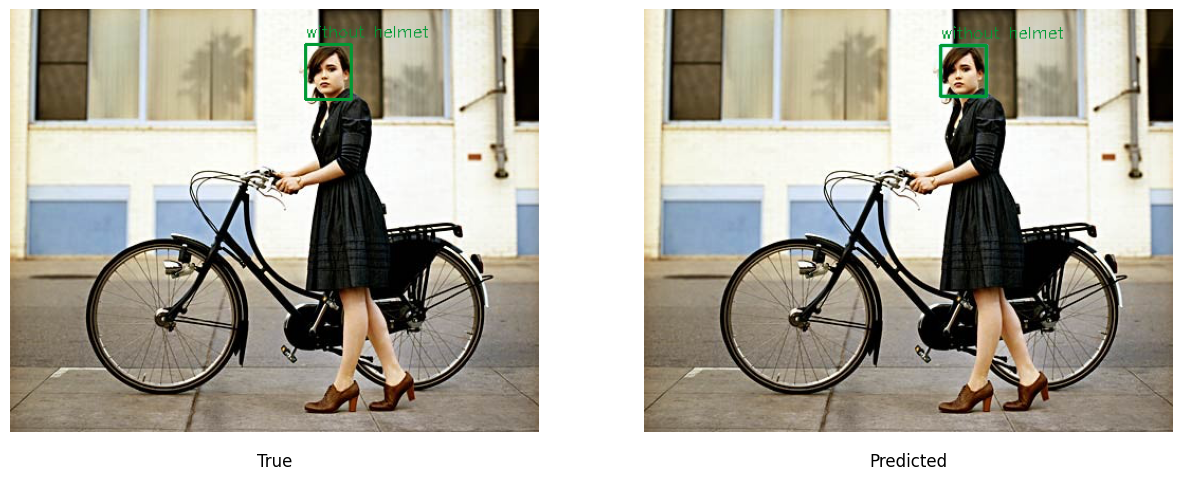

In [ ]:
from os import listdir
from os.path import isfile, join
test_images = [f for f in listdir(TEST_IMAGES_DIR) if isfile(join(TEST_IMAGES_DIR, f))]

selected_image = random.choice(test_images)

yolo_label_path = os.path.join(results_dir, f"labels/{str.replace(selected_image,'png','txt')}")
yolo_image = os.path.join(results_dir, selected_image)

if not os.path.isfile(yolo_label_path):
  print(yolo_label_path)
  print(f"YOLO failed to make predictions for image '{selected_image}'")
  yolo_label_path = None
  yolo_image = os.path.join(TEST_IMAGES_DIR, selected_image)

compare_images([os.path.join(TEST_IMAGES_DIR, selected_image), yolo_image], label_paths=[None, yolo_label_path], titles=['True','Predicted'])

Quando `logging == True`, o trecho de código abaixo é usado para registrar as métricas calculadas sobre o modelo de teste e as tags que identificam o modelo.

### (Opcional) Registrando tags e resultados do modelo no MLflow/Dagshub

In [ ]:
if logging:
  last_run = mlflow.search_runs(search_all_experiments=True).loc[0,'run_id']
  with mlflow.start_run(run_id=last_run):
    mlflow.set_tag('MODEL_NAME', MODEL_NAME)
    mlflow.set_tag('TRAIN_DATA', 'MERGED DATASET' if 'merged' in TRAIN_DATA_YAML else 'DATASET 1')
    mlflow.set_tag('EPOCHS', EPOCHS)

    mlflow.log_metric('test_precision',results_dict['metrics/precision(B)'])
    mlflow.log_metric('test_recall',results_dict['metrics/recall(B)'])
    mlflow.log_metric('test_map50',results_dict['metrics/mAP50(B)'])
    mlflow.log_metric('test_map50-95',results_dict['metrics/mAP50-95(B)'])
    mlflow.log_metric('test_fitness',results_dict['fitness'])